# TP2: Feature Detection, Matching and Epipolar Geometry

In [2]:
# Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import feature
import time
from pathlib import Path
import zipfile
from google.colab import files


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
K = np.array([[718.8, 0, 607.1],
              [0, 718.8, 185.2],
              [0, 0, 1]])

In [17]:
# Charger les images
img1 = cv2.imread("/content/drive/MyDrive/SLAM/TP1/TP1-20260114/Pairs/000392_d.png", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("/content/drive/MyDrive/SLAM/TP1/TP1-20260114/Pairs/000392_g.png", cv2.IMREAD_GRAYSCALE)

print(f"Images chargées: {img1.shape}, {img2.shape}")

Images chargées: (376, 1241), (376, 1241)


### Upload des images pour la séquence (TP2_bis)

In [5]:
# Upload de la séquence (pour TP2_bis)
sequence_path = Path("/content/drive/MyDrive/SLAM/TP1/TP1-20260114/Sequence/")

# Lister les images
sequence_files = sorted(list(sequence_path.glob('*.png')) + list(sequence_path.glob('*.jpg')))

print(f"{len(sequence_files)} images extraites")
for i, img_file in enumerate(sequence_files[:5]):
    print(f"  {i+1}. {img_file.name}")
if len(sequence_files) > 5:
    print(f"  ... et {len(sequence_files)-5} autres")

5 images extraites
  1. 000358.png
  2. 000359.png
  3. 000360.png
  4. 000361.png
  5. 000362.png


---
# Partie 1: SIFT et ORB Keypoints

## 1.a) Extraction et Comparaison SIFT/ORB

In [6]:
# Extraction SIFT avec OpenCV
def extract_sift_opencv(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

# Extraction ORB avec OpenCV
def extract_orb_opencv(image, nfeatures=2000):
    orb = cv2.ORB_create(nfeatures=nfeatures)
    keypoints, descriptors = orb.detectAndCompute(image, None)
    return keypoints, descriptors

# Extraction SIFT avec scikit-image
def extract_sift_skimage(image):
    from skimage.feature import SIFT
    sift_detector = SIFT()
    sift_detector.detect_and_extract(image)
    keypoints = sift_detector.keypoints
    descriptors = sift_detector.descriptors
    return keypoints, descriptors


In [18]:
# Extraction avec les différentes méthodes
print("Extraction SIFT (OpenCV)...")
start = time.time()
kp_sift_cv1, desc_sift_cv1 = extract_sift_opencv(img1)
kp_sift_cv2, desc_sift_cv2 = extract_sift_opencv(img2)
time_sift_cv = time.time() - start

print("Extraction ORB (OpenCV)...")
start = time.time()
kp_orb_cv1, desc_orb_cv1 = extract_orb_opencv(img1)
kp_orb_cv2, desc_orb_cv2 = extract_orb_opencv(img2)
time_orb_cv = time.time() - start

print("Extraction SIFT (scikit-image)...")
start = time.time()
kp_sift_sk1, desc_sift_sk1 = extract_sift_skimage(img1)
kp_sift_sk2, desc_sift_sk2 = extract_sift_skimage(img2)
time_sift_sk = time.time() - start

print(f"\nRésultats:")
print(f"SIFT (OpenCV): {len(kp_sift_cv1)} keypoints en {time_sift_cv:.3f}s")
print(f"ORB (OpenCV): {len(kp_orb_cv1)} keypoints en {time_orb_cv:.3f}s")
print(f"SIFT (scikit-image): {len(kp_sift_sk1)} keypoints en {time_sift_sk:.3f}s")

Extraction SIFT (OpenCV)...
Extraction ORB (OpenCV)...
Extraction SIFT (scikit-image)...

Résultats:
SIFT (OpenCV): 2780 keypoints en 0.464s
ORB (OpenCV): 1957 keypoints en 0.042s
SIFT (scikit-image): 3158 keypoints en 7.975s


(np.float64(-0.5), np.float64(1240.5), np.float64(375.5), np.float64(-0.5))

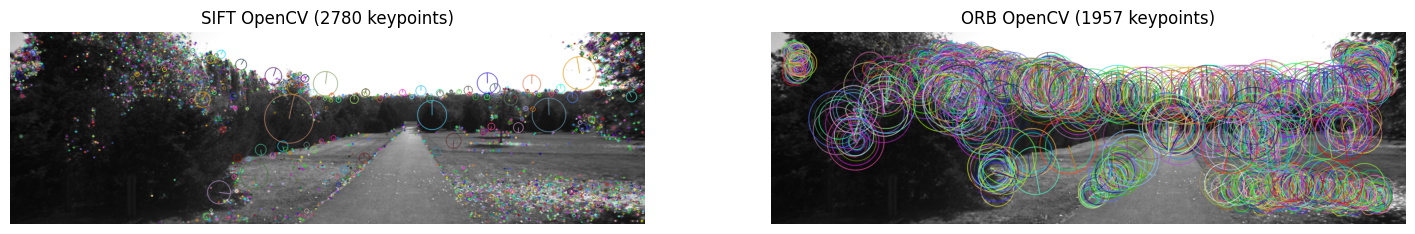

In [19]:
# Visualisation des keypoints
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

img_sift_cv = cv2.drawKeypoints(img1, kp_sift_cv1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
axes[0].imshow(img_sift_cv)
axes[0].set_title(f'SIFT OpenCV ({len(kp_sift_cv1)} keypoints)')
axes[0].axis('off')

img_orb_cv = cv2.drawKeypoints(img1, kp_orb_cv1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
axes[1].imshow(img_orb_cv)
axes[1].set_title(f'ORB OpenCV ({len(kp_orb_cv1)} keypoints)')
axes[1].axis('off')


=> SIFT détecte davantage de points clés (2780 contre 1957) et les répartit de façon plus fine et plus homogène sur toute la scène, en particulier sur les textures riches et les zones de contraste, ce qui le rend très robuste aux changements d’échelle et de rotation. En revanche, ORB concentre ses points clés sur des structures plus marquées (bords, lignes, zones très contrastées), avec des cercles souvent plus grands et plus regroupés, ce qui reflète son approche plus rapide et plus simple.

En résumé, SIFT privilégie la précision et la richesse descriptive, au prix d’un coût de calcul plus élevé, tandis que ORB favorise la rapidité et l’efficacité, avec moins de points mais un traitement plus léger, souvent mieux adapté aux applications temps réel

## 1.b) Méthodologie de Comparaison SIFT vs ORB

Nous allons comparer selon les critères suivants:
1. Nombre de keypoints détectés
2. Précision du matching
3. Robustesse aux outliers (via RANSAC)
4. Temps d'exécution

In [7]:
# Fonction de matching
def match_features(desc1, desc2, method='SIFT', ratio_threshold=0.75):
    if method == 'SIFT':
        matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    else:  # ORB
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

    # KNN matching
    matches = matcher.knnMatch(desc1, desc2, k=2)

    # Ratio test
    good_matches = []
    for match_pair in matches:
        if len(match_pair) == 2:
            m, n = match_pair
            if m.distance < ratio_threshold * n.distance:
                good_matches.append(m)

    return good_matches


In [20]:
# Matching SIFT
print("Matching SIFT...")
start = time.time()
matches_sift = match_features(desc_sift_cv1, desc_sift_cv2, method='SIFT')
time_match_sift = time.time() - start

# Matching ORB
print("Matching ORB...")
start = time.time()
matches_orb = match_features(desc_orb_cv1, desc_orb_cv2, method='ORB')
time_match_orb = time.time() - start

print(f"\nRésultats matching:")
print(f"SIFT: {len(matches_sift)} matches en {time_match_sift:.3f}s")
print(f"ORB: {len(matches_orb)} matches en {time_match_orb:.3f}s")

Matching SIFT...
Matching ORB...

Résultats matching:
SIFT: 514 matches en 0.281s
ORB: 444 matches en 0.076s


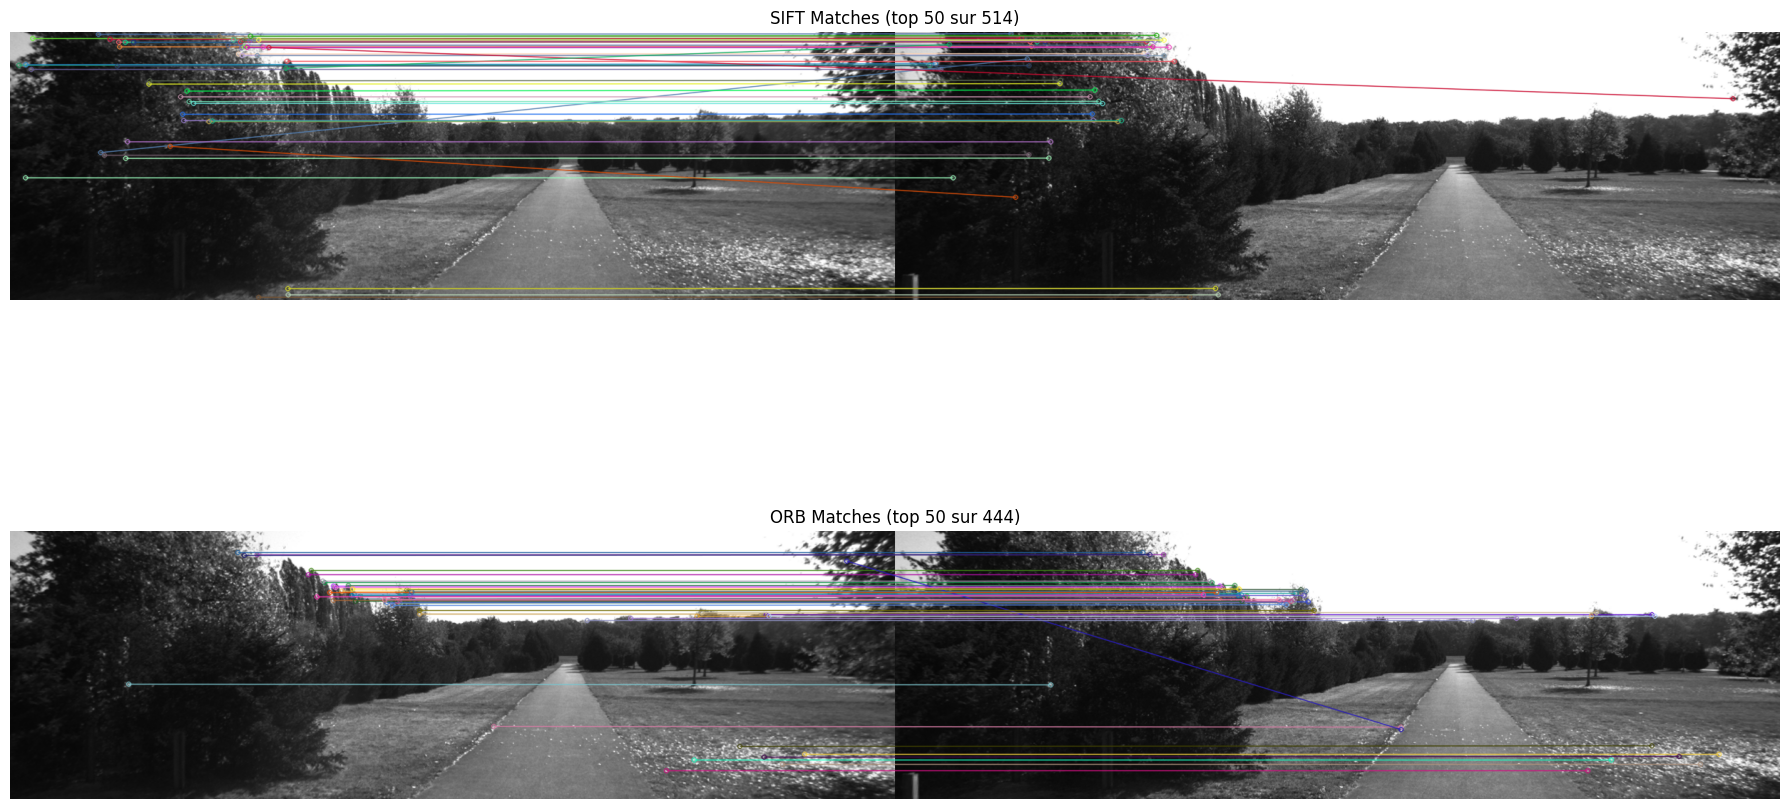

In [21]:
# Visualisation des matches
img_matches_sift = cv2.drawMatches(img1, kp_sift_cv1, img2, kp_sift_cv2,
                                   matches_sift[:50], None,
                                   flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

img_matches_orb = cv2.drawMatches(img1, kp_orb_cv1, img2, kp_orb_cv2,
                                  matches_orb[:50], None,
                                  flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

fig, axes = plt.subplots(2, 1, figsize=(18, 12))
axes[0].imshow(img_matches_sift)
axes[0].set_title(f'SIFT Matches (top 50 sur {len(matches_sift)})')
axes[0].axis('off')

axes[1].imshow(img_matches_orb)
axes[1].set_title(f'ORB Matches (top 50 sur {len(matches_orb)})')
axes[1].axis('off')

plt.tight_layout()
plt.show()

=> Avec SIFT, on observe un très grand nombre de matches, répartis sur presque toute la scène, ce qui traduit une forte capacité à retrouver des points similaires malgré les variations de perspective et de texture ; cependant, cette abondance inclut aussi davantage de correspondances moins pertinentes ou redondantes, visibles par des lignes très denses et parfois incohérentes. À l’inverse, ORB produit moins de matches, mais ils sont globalement plus structurés et plus réguliers, principalement alignés sur les zones à forts contours, ce qui suggère des correspondances plus sélectives et un meilleur compromis pour des applications rapides.

---
# Partie 2: Explication du Feature Matching

Le matching de caractéristiques pour SIFT et ORB repose sur la comparaison de descripteurs associés aux points clés détectés dans deux images.

Pour SIFT, les descripteurs sont des vecteurs réels de 128 dimensions, et la mise en correspondance se fait généralement en calculant la distance euclidienne (L2) entre ces vecteurs : un point est apparié avec celui dont le descripteur est le plus proche.

Pour ORB, les descripteurs sont binaires, ce qui permet d’utiliser une distance de Hamming, beaucoup plus rapide à calculer, rendant ORB mieux adapté aux applications temps réel. Le choix de la métrique de distance est donc crucial, car elle doit être cohérente avec la nature du descripteur afin de mesurer correctement la similarité entre points.
Toutefois, un simple appariement par distance minimale génère souvent des correspondances incorrectes ; il est donc essentiel de les filtrer, par exemple à l’aide du ratio test de Lowe (comparaison entre le meilleur et le second meilleur match) ou de méthodes géométriques comme RANSAC, qui éliminent les outliers et conservent uniquement les matches cohérents avec la géométrie de la scène.

---
# Partie 3: Fundamental Matrix sans High-Level Libraries

## 3.1: Algorithme des 8 Points



In [8]:
def normalize_points(points):

    # Calculer centroid
    centroid = np.mean(points, axis=0)

    # Centrer les points
    centered = points - centroid

    # Calculer la distance moyenne au centroid
    mean_dist = np.mean(np.sqrt(np.sum(centered**2, axis=1)))

    # Facteur d'échelle pour obtenir distance moyenne = sqrt(2)
    scale = np.sqrt(2) / mean_dist

    # Matrice de transformation
    T = np.array([
        [scale, 0, -scale * centroid[0]],
        [0, scale, -scale * centroid[1]],
        [0, 0, 1]
    ])

    # Appliquer la transformation
    ones = np.ones((points.shape[0], 1))
    points_homog = np.hstack([points, ones])
    normalized = (T @ points_homog.T).T

    return normalized[:, :2], T


In [9]:
def eight_point_algorithm(pts1, pts2, normalize=True):

    assert pts1.shape[0] >= 8, "Au moins 8 points requis"

    # Normalisation
    if normalize:
        pts1_norm, T1 = normalize_points(pts1)
        pts2_norm, T2 = normalize_points(pts2)
    else:
        pts1_norm = pts1
        pts2_norm = pts2
        T1 = T2 = np.eye(3)

    # Construire la matrice A
    N = pts1_norm.shape[0]
    A = np.zeros((N, 9))

    for i in range(N):
        x1, y1 = pts1_norm[i]
        x2, y2 = pts2_norm[i]
        A[i] = [x1*x2, x1*y2, x1, y1*x2, y1*y2, y1, x2, y2, 1]

    # SVD de A
    U, S, Vt = np.linalg.svd(A)

    # F est la dernière ligne de V (dernière colonne de Vt)
    F = Vt[-1].reshape(3, 3)

    # Imposer la contrainte de rang 2
    U_f, S_f, Vt_f = np.linalg.svd(F)
    S_f[-1] = 0  # Mettre la plus petite valeur singulière à 0
    F = U_f @ np.diag(S_f) @ Vt_f

    # Dénormaliser
    if normalize:
        F = np.transpose(T2) @ F @ T1

    return F


3.1) L’algorithme des huit points sert à estimer la matrice fondamentale à partir d’au moins huit paires de points correspondants entre deux images. Il consiste d’abord à écrire, pour chaque correspondance, une équation linéaire issue de la contrainte épipolaire, puis à empiler ces équations dans un système matriciel qui est résolu (généralement par décomposition en valeurs singulières, SVD) afin d’obtenir une première estimation de la matrice fondamentale.

La normalisation des points est essentielle car elle améliore fortement la stabilité numérique du calcul : en recentrant les points autour de l’origine et en les mettant à une échelle comparable, on évite que les coordonnées de grande amplitude dominent le système et dégradent la précision de la solution.

Une fois la matrice estimée, la contrainte de rang 2 est imposée pour respecter la propriété géométrique fondamentale de la matrice fondamentale ; cela se fait en calculant sa SVD, en annulant la plus petite valeur singulière, puis en reconstruisant la matrice. Enfin, on dé-normalise la matrice obtenue afin de l’exprimer dans le repère original des images.



In [22]:
# Test de l'algorithme des 8 points avec SIFT
pts1_sift = np.float32([kp_sift_cv1[m.queryIdx].pt for m in matches_sift]).reshape(-1, 2)
pts2_sift = np.float32([kp_sift_cv2[m.trainIdx].pt for m in matches_sift]).reshape(-1, 2)

print("Test avec les 8 premiers points SIFT:")
F_8pt = eight_point_algorithm(pts1_sift[:8], pts2_sift[:8])
print("\nMatrice F (8 points):")
print(F_8pt)
print(f"\nRang de F: {np.linalg.matrix_rank(F_8pt)}")
print(f"Det(F): {np.linalg.det(F_8pt):.2e}")

Test avec les 8 premiers points SIFT:

Matrice F (8 points):
[[-1.45419315e-05  4.48173084e-05 -1.48150596e-02]
 [-4.02348806e-05  6.89198496e-07  3.88730767e-03]
 [ 1.48162038e-02 -6.83908457e-03  9.65160242e-01]]

Rang de F: 2
Det(F): 0.00e+00


## Partie 4: RANSAC pour Estimation Robuste

### 3.2 Implémentation RANSAC

In [10]:
def compute_epipolar_distance(F, pts1, pts2):

    # Convertir en coordonnées homogènes
    ones = np.ones((pts1.shape[0], 1))
    pts1_h = np.hstack([pts1, ones])
    pts2_h = np.hstack([pts2, ones])

    # Distance épipolaire: |x2^T F x1| / sqrt((Fx1)_1^2 + (Fx1)_2^2)
    Fx1 = (F @ pts1_h.T).T
    x2Fx1 = np.sum(pts2_h * Fx1, axis=1)

    distances = np.abs(x2Fx1) / np.sqrt(Fx1[:, 0]**2 + Fx1[:, 1]**2)

    return distances



In [11]:
def ransac_fundamental_matrix(pts1, pts2, threshold=3.0, max_iterations=1000, confidence=0.99):

    N = pts1.shape[0]
    best_F = None
    best_inliers = None
    best_inlier_count = 0

    for iteration in range(max_iterations):
        # 1. Échantillonnage aléatoire de 8 points
        indices = np.random.choice(N, 8, replace=False)
        sample_pts1 = pts1[indices]
        sample_pts2 = pts2[indices]

        # 2. Estimer F avec ces 8 points
        try:
            F = eight_point_algorithm(sample_pts1, sample_pts2)
        except:
            continue

        # 3. Calculer les distances épipolaires
        distances = compute_epipolar_distance(F, pts1, pts2)

        # 4. Compter les inliers
        inliers = distances < threshold
        inlier_count = np.sum(inliers)

        # 5. Mettre à jour le meilleur modèle
        if inlier_count > best_inlier_count:
            best_inlier_count = inlier_count
            best_F = F
            best_inliers = inliers

    # Raffiner F avec tous les inliers
    if best_inliers is not None and np.sum(best_inliers) >= 8:
        best_F = eight_point_algorithm(pts1[best_inliers], pts2[best_inliers])

    return best_F, best_inliers



### Principe de RANSAC:
RANSAC est un algorithme robuste utilisé pour estimer la matrice fondamentale en présence de correspondances erronées (outliers). Son principe consiste à sélectionner de manière aléatoire un petit sous-ensemble minimal de correspondances (par exemple huit paires de points pour la matrice fondamentale), à estimer un modèle candidat à partir de cet échantillon, puis à évaluer ce modèle sur l’ensemble des correspondances en comptant le nombre d’inliers, c’est-à-dire les points qui respectent la contrainte épipolaire à l’intérieur d’un seuil d’erreur donné. Cette procédure est répétée un grand nombre de fois afin d’augmenter la probabilité de trouver un échantillon composé uniquement de correspondances correctes. Le modèle qui maximise le nombre d’inliers est retenu, puis la matrice fondamentale est ré-estimée de façon plus précise en utilisant l’ensemble de ces inliers, ce qui permet d’obtenir une estimation fiable malgré la présence de bruit et de faux appariements.


**Étapes:**
1. Échantillonner aléatoirement 8 correspondances
2. Calculer F avec l'algorithme des 8 points
3. Calculer la distance épipolaire pour toutes les correspondances
4. Compter les inliers (distance < seuil)
5. Garder le modèle avec le plus d'inliers
6. Raffiner F avec tous les inliers


In [23]:
# Appliquer RANSAC sur SIFT
print("Application de RANSAC sur SIFT...")
start = time.time()
F_sift, inliers_sift = ransac_fundamental_matrix(pts1_sift, pts2_sift, threshold=3.0)
time_ransac_sift = time.time() - start

print(f"\nRésultats SIFT:")
print(f"Inliers: {np.sum(inliers_sift)}/{len(inliers_sift)} ({100*np.sum(inliers_sift)/len(inliers_sift):.1f}%)")
print(f"Temps: {time_ransac_sift:.3f}s")
print(f"\nMatrice F:")
print(F_sift)
print(f"Det(F): {np.linalg.det(F_sift):.2e}")

Application de RANSAC sur SIFT...

Résultats SIFT:
Inliers: 487/514 (94.7%)
Temps: 0.445s

Matrice F:
[[-5.24764496e-11  4.02783896e-08  7.96340734e-06]
 [-5.10981994e-08  1.45287792e-08  3.64775489e-03]
 [-5.96575541e-06 -3.77957731e-03  2.98213649e-02]]
Det(F): -3.27e-31


In [24]:
# Appliquer RANSAC sur ORB
pts1_orb = np.float32([kp_orb_cv1[m.queryIdx].pt for m in matches_orb]).reshape(-1, 2)
pts2_orb = np.float32([kp_orb_cv2[m.trainIdx].pt for m in matches_orb]).reshape(-1, 2)

print("Application de RANSAC sur ORB...")
start = time.time()
F_orb, inliers_orb = ransac_fundamental_matrix(pts1_orb, pts2_orb, threshold=3.0)
time_ransac_orb = time.time() - start

print(f"\nRésultats ORB:")
print(f"Inliers: {np.sum(inliers_orb)}/{len(inliers_orb)} ({100*np.sum(inliers_orb)/len(inliers_orb):.1f}%)")
print(f"Temps: {time_ransac_orb:.3f}s")
print(f"\nMatrice F:")
print(F_orb)
print(f"Det(F): {np.linalg.det(F_orb):.2e}")

Application de RANSAC sur ORB...

Résultats ORB:
Inliers: 430/444 (96.8%)
Temps: 0.445s

Matrice F:
[[-4.40579918e-11  3.00139589e-07 -5.35104183e-05]
 [-2.79062787e-07  4.67410181e-08 -4.00686101e-03]
 [ 4.93614290e-05  4.06607243e-03 -9.07931134e-03]]
Det(F): -7.70e-30


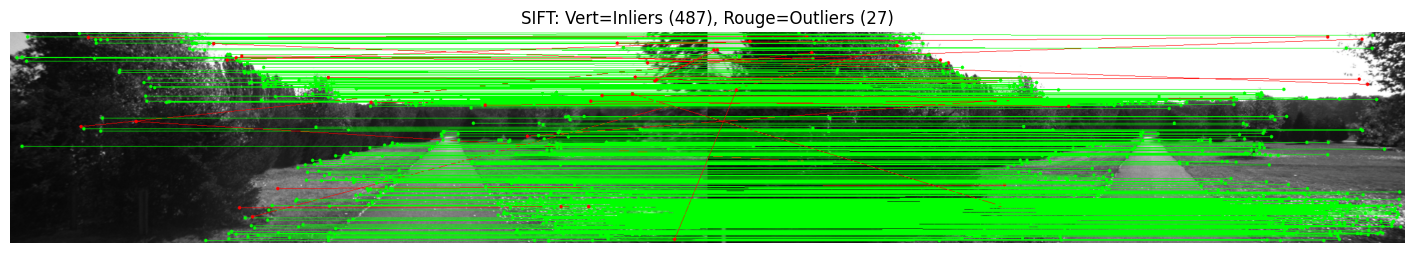

In [25]:
# Visualisation des inliers vs outliers
def visualize_inliers_outliers(img1, img2, kp1, kp2, matches, inliers):
    """
    Visualiser inliers (vert) et outliers (rouge)
    """
    h1, w1 = img1.shape
    h2, w2 = img2.shape
    vis = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
    vis[:h1, :w1] = cv2.cvtColor(img1, cv2.COLOR_GRAY2RGB)
    vis[:h2, w1:] = cv2.cvtColor(img2, cv2.COLOR_GRAY2RGB)

    for i, m in enumerate(matches):
        pt1 = tuple(map(int, kp1[m.queryIdx].pt))
        pt2 = tuple(map(int, kp2[m.trainIdx].pt))
        pt2 = (pt2[0] + w1, pt2[1])

        color = (0, 255, 0) if inliers[i] else (255, 0, 0)
        cv2.line(vis, pt1, pt2, color, 1)
        cv2.circle(vis, pt1, 3, color, -1)
        cv2.circle(vis, pt2, 3, color, -1)

    return vis

# Visualiser SIFT
vis_sift = visualize_inliers_outliers(img1, img2, kp_sift_cv1, kp_sift_cv2, matches_sift, inliers_sift)

plt.figure(figsize=(18, 8))
plt.imshow(vis_sift)
plt.title(f'SIFT: Vert=Inliers ({np.sum(inliers_sift)}), Rouge=Outliers ({np.sum(~inliers_sift)})')
plt.axis('off')
plt.show()

---
# Partie 4: Essential Matrix


5) **Relation mathématique:**
$$E = K^T F K$$

**Contraintes géométriques sur E:**
1. Rang 2: det(E) = 0
2. Deux valeurs singulières égales: σ₁ = σ₂, σ₃ = 0
3. Structure: E = [t]ₓ R


In [12]:
def compute_essential_matrix(F, K):

    E = np.matmul(np.transpose(K), np.matmul(F, K))

    # Imposer les contraintes sur E: 2 valeurs singulières égales, 1 nulle
    U, S, Vt = np.linalg.svd(E)
    S_new = np.array([(S[0] + S[1]) / 2, (S[0] + S[1]) / 2, 0])
    E = U @ np.diag(S_new) @ Vt

    return E


In [26]:
# Calculer E pour SIFT et ORB
E_sift = compute_essential_matrix(F_sift, K)
E_orb = compute_essential_matrix(F_orb, K)

print("Matrice E (SIFT):")
print(E_sift)
U, S, Vt = np.linalg.svd(E_sift)
print(f"Valeurs singulières: {S}")
print(f"Det(E): {np.linalg.det(E_sift):.2e}")

print("\nMatrice E (ORB):")
print(E_orb)
U, S, Vt = np.linalg.svd(E_orb)
print(f"Valeurs singulières: {S}")
print(f"Det(E): {np.linalg.det(E_orb):.2e}")

Matrice E (SIFT):
[[-3.06450566e-05  2.04393271e-02  1.12609331e-02]
 [-2.68897158e-02  6.70840668e-03  2.64941527e+00]
 [-1.09257280e-02 -2.64947479e+00  6.68482048e-03]]
Valeurs singulières: [2.64958437e+00 2.64958437e+00 4.05312772e-18]
Det(E): 1.24e-19

Matrice E (ORB):
[[ 4.24860186e-06  1.53442127e-01  2.01340321e-03]
 [-1.45732225e-01  1.37298088e-02 -3.02798211e+00]
 [-1.16789259e-03  3.02760094e+00  1.37174965e-02]]
Valeurs singulières: [3.03151839e+00 3.03151839e+00 6.25928530e-17]
Det(E): 5.74e-19


In [27]:
# Récupérer R et t depuis E
def recover_pose_from_E(E, pts1, pts2, K):
    """
    Récupérer R et t depuis E
    """
    _, R, t, mask = cv2.recoverPose(E, pts1, pts2, K)
    return R, t, mask

# Pour SIFT
R_sift, t_sift, mask_pose_sift = recover_pose_from_E(E_sift, pts1_sift[inliers_sift],
                                                       pts2_sift[inliers_sift], K)

print("Pose SIFT:")
print("Rotation R:")
print(R_sift)
print(f"\nTranslation t:")
print(t_sift.flatten())
print(f"Norme: {np.linalg.norm(t_sift):.6f}")

# Pour ORB
R_orb, t_orb, mask_pose_orb = recover_pose_from_E(E_orb, pts1_orb[inliers_orb],
                                                    pts2_orb[inliers_orb], K)

print("\nPose ORB:")
print("Rotation R:")
print(R_orb)
print(f"\nTranslation t:")
print(t_orb.flatten())
print(f"Norme: {np.linalg.norm(t_orb):.6f}")

Pose SIFT:
Rotation R:
[[ 9.99996999e-01  1.52242753e-04  2.44502165e-03]
 [-1.46048222e-04  9.99996780e-01 -2.53350705e-03]
 [-2.44539949e-03  2.53314236e-03  9.99993802e-01]]

Translation t:
[ 0.99996121 -0.00426962  0.00770337]
Norme: 1.000000

Pose ORB:
Rotation R:
[[ 9.99996750e-01 -6.11300679e-05  2.54859016e-03]
 [ 4.95797041e-05  9.99989730e-01  4.53187698e-03]
 [-2.54884102e-03 -4.53173589e-03  9.99986483e-01]]

Translation t:
[ 9.98717988e-01  4.34767597e-04 -5.06180917e-02]
Norme: 1.000000


---
# Partie 5: Analyse Comparative SIFT vs ORB


In [28]:
# Tableau comparatif
import pandas as pd

comparison = {
    'Critère': [
        'Nombre de keypoints',
        'Nombre de matches',
        'Inliers après RANSAC',
        'Pourcentage inliers',
        'Temps extraction (s)',
        'Temps matching (s)',
        'Temps RANSAC (s)',
        'Temps total (s)'
    ],
    'SIFT': [
        len(kp_sift_cv1),
        len(matches_sift),
        np.sum(inliers_sift),
        f"{100*np.sum(inliers_sift)/len(inliers_sift):.1f}%",
        f"{time_sift_cv:.3f}",
        f"{time_match_sift:.3f}",
        f"{time_ransac_sift:.3f}",
        f"{time_sift_cv + time_match_sift + time_ransac_sift:.3f}"
    ],
    'ORB': [
        len(kp_orb_cv1),
        len(matches_orb),
        np.sum(inliers_orb),
        f"{100*np.sum(inliers_orb)/len(inliers_orb):.1f}%",
        f"{time_orb_cv:.3f}",
        f"{time_match_orb:.3f}",
        f"{time_ransac_orb:.3f}",
        f"{time_orb_cv + time_match_orb + time_ransac_orb:.3f}"
    ]
}

df = pd.DataFrame(comparison)
print("\nTableau Comparatif SIFT vs ORB:")
print(df.to_string(index=False))


Tableau Comparatif SIFT vs ORB:
             Critère  SIFT   ORB
 Nombre de keypoints  2780  1957
   Nombre de matches   514   444
Inliers après RANSAC   487   430
 Pourcentage inliers 94.7% 96.8%
Temps extraction (s) 0.464 0.042
  Temps matching (s) 0.281 0.076
    Temps RANSAC (s) 0.445 0.445
     Temps total (s) 1.189 0.564


6) Analyse des Trade-offs:

**SIFT:**
- **Avantages:**
  - Très robuste aux changements d'échelle et rotation
  - Descripteurs plus distinctifs (128 dimensions)
  - Meilleur taux d'inliers généralement
  - Plus stable pour l'estimation de F et E

- **Inconvénients:**
  - Plus lent (calcul des descripteurs)
  - Nécessite plus de mémoire
  - Matching plus coûteux (distance L2)

=> Applications hors-ligne, haute précision requise, variations importantes

**ORB:**
- **Avantages:**
  - Très rapide (descripteurs binaires)
  - Efficace en mémoire
  - Bon pour applications temps-réel
  - Matching rapide (distance Hamming)

- **Inconvénients:**
  - Moins robuste aux grandes transformations
  - Taux d'inliers souvent plus faible
  - Peut nécessiter plus de keypoints

=> Applications temps-réel, ressources limitées, petites variations

---
# TP2_bis: Estimation de Poses Successives

## Partie 1: Automatisation sur Séquence


In [14]:
def process_image_pair(img1, img2, K, method='SIFT'):

    # 1. Extraction de features
    if method == 'SIFT':
        kp1, desc1 = extract_sift_opencv(img1)
        kp2, desc2 = extract_sift_opencv(img2)
    else:
        kp1, desc1 = extract_orb_opencv(img1)
        kp2, desc2 = extract_orb_opencv(img2)

    # 2. Matching
    matches = match_features(desc1, desc2, method=method)

    if len(matches) < 8:
        return None, None, 0

    # 3. Extraire points
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 2)

    # 4. RANSAC pour F
    F, inliers = ransac_fundamental_matrix(pts1, pts2)

    if inliers is None or np.sum(inliers) < 8:
        return None, None, 0

    # 5. Calculer E
    E = compute_essential_matrix(F, K)

    # 6. Récupérer R et t
    R, t, _ = recover_pose_from_E(E, pts1[inliers], pts2[inliers], K)

    return R, t, np.sum(inliers)


In [15]:
def process_sequence(image_files, K, method='SIFT'):

    poses = [np.eye(4)]  # Pose initiale
    current_pose = np.eye(4)

    for i in range(len(image_files) - 1):
        print(f"Traitement paire {i+1}/{len(image_files)-1}", end='\r')

        # Charger images
        img1 = cv2.imread(str(image_files[i]), cv2.IMREAD_GRAYSCALE)
        img2 = cv2.imread(str(image_files[i+1]), cv2.IMREAD_GRAYSCALE)

        # Traiter la paire
        R, t, inliers = process_image_pair(img1, img2, K, method)

        if R is None:
            print(f"\nÉchec paire {i+1}")
            continue

        # Créer matrice de transformation
        T = np.eye(4)
        T[:3, :3] = R
        T[:3, 3] = t.flatten()

        # Accumuler
        current_pose = current_pose @ T
        poses.append(current_pose.copy())

    print(f"\nTraitement terminé: {len(poses)} poses")
    return poses


In [29]:
# Traiter la séquence
print("Traitement de la séquence avec SIFT...")
poses_sift = process_sequence(sequence_files, K, method='SIFT')

print(f"\nNombre de poses estimées: {len(poses_sift)}")

Traitement de la séquence avec SIFT...

Traitement terminé: 5 poses

Nombre de poses estimées: 5


## Partie2: Visualisation de la Trajectoire

3-a) Visualisation avec Open3D:  
Open3D nécessite un environnement graphique
Sur Colab, la visualisation  ne fonctionne pas

3-b) Visualisation avec Plotly

In [54]:
import plotly.graph_objects as go
import numpy as np

def visualize_trajectory(poses):
    """
    poses: Liste de matrices 4x4 [T1, T2, ...]
    """
    cam_centers = []

    # Création de la figure
    fig = go.Figure()

    for i, T in enumerate(poses):
        # 1. Extraire R et t
        R = T[:3, :3]
        t = T[:3, 3]

        # 2. Calculer le centre de la caméra : C = -R^T * t
        center = -R.T @ t
        cam_centers.append(center)

        # 3. Ajouter un repère local pour chaque caméra (axes X, Y, Z)
        # On trace des vecteurs courts pour montrer l'orientation
        scale = 0.2  # Taille des axes du repère
        for j, color in enumerate(['red', 'green', 'blue']): # X, Y, Z
            axis = center + R.T[:, j] * scale
            fig.add_trace(go.Scatter3d(
                x=[center[0], axis[0]],
                y=[center[1], axis[1]],
                z=[center[2], axis[2]],
                mode='lines',
                line=dict(color=color, width=4),
                showlegend=False
            ))

        # Ajouter un label pour le numéro de l'image
        fig.add_trace(go.Scatter3d(
            x=[center[0]], y=[center[1]], z=[center[2]],
            mode='markers+text',
            marker=dict(size=5, color='black'),
            text=[f"Cam {i}"],
            textposition="top center",
            name=f"Pose {i}"
        ))

    # 4. Tracer la ligne de trajectoire reliant les centres
    cam_centers = np.array(cam_centers)
    fig.add_trace(go.Scatter3d(
        x=cam_centers[:, 0],
        y=cam_centers[:, 1],
        z=cam_centers[:, 2],
        mode='lines',
        line=dict(color='gray', width=2, dash='dash'),
        name='Trajectoire'
    ))

    # Configuration des axes
    fig.update_layout(
        scene=dict(
            xaxis_title='X (monde)',
            yaxis_title='Y (monde)',
            zaxis_title='Z (monde)',
            aspectmode='data' # Garde les proportions réelles
        ),
        title="Trajectoire 3D des caméras",
        showlegend=True
    )

    fig.show()

In [55]:
# Visualiser avec Plotly
visualize_trajectory(poses_sift)

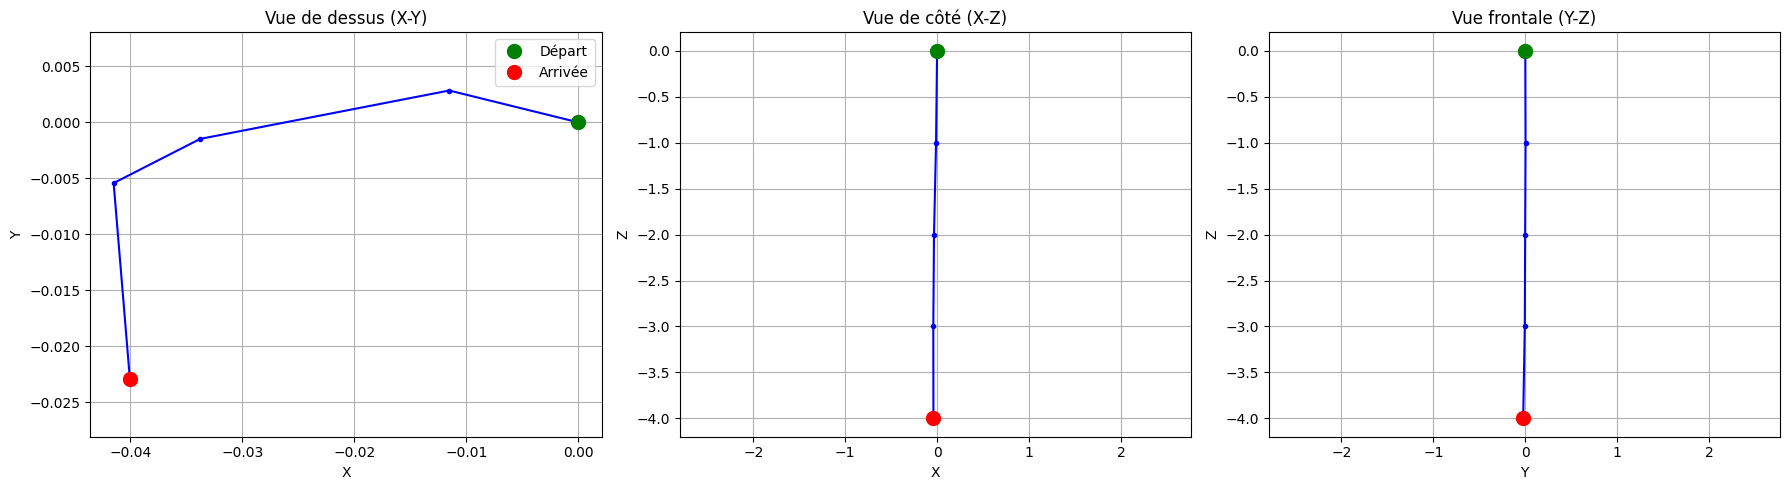

In [48]:
# Visualisation avec matplotlib (vue 2D)
def visualize_trajectory_2d(poses):

    positions = np.array([pose[:3, 3] for pose in poses])

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Vue XY (dessus)
    axes[0].plot(positions[:, 0], positions[:, 1], 'b-o', markersize=3)
    axes[0].plot(positions[0, 0], positions[0, 1], 'go', markersize=10, label='Départ')
    axes[0].plot(positions[-1, 0], positions[-1, 1], 'ro', markersize=10, label='Arrivée')
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')
    axes[0].set_title('Vue de dessus (X-Y)')
    axes[0].legend()
    axes[0].grid(True)
    axes[0].axis('equal')

    # Vue XZ (côté)
    axes[1].plot(positions[:, 0], positions[:, 2], 'b-o', markersize=3)
    axes[1].plot(positions[0, 0], positions[0, 2], 'go', markersize=10)
    axes[1].plot(positions[-1, 0], positions[-1, 2], 'ro', markersize=10)
    axes[1].set_xlabel('X')
    axes[1].set_ylabel('Z')
    axes[1].set_title('Vue de côté (X-Z)')
    axes[1].grid(True)
    axes[1].axis('equal')

    # Vue YZ (face)
    axes[2].plot(positions[:, 1], positions[:, 2], 'b-o', markersize=3)
    axes[2].plot(positions[0, 1], positions[0, 2], 'go', markersize=10)
    axes[2].plot(positions[-1, 1], positions[-1, 2], 'ro', markersize=10)
    axes[2].set_xlabel('Y')
    axes[2].set_ylabel('Z')
    axes[2].set_title('Vue frontale (Y-Z)')
    axes[2].grid(True)
    axes[2].axis('equal')

    plt.tight_layout()
    plt.show()

visualize_trajectory_2d(poses_sift)

## Partie: Comparaison avec cv2.solvePnP



In [50]:
def process_sequence_with_pnp(image_files, K, method='SIFT'):
    # Initialize:
    poses = [np.eye(4)]
    current_pose_abs = np.eye(4) # Absolute pose relative to the first image

    # Process the First Pair (img0 and img1) for Initial Triangulation
    print("Processing first image pair for triangulation...")
    img0 = cv2.imread(str(image_files[0]), cv2.IMREAD_GRAYSCALE)
    img1 = cv2.imread(str(image_files[1]), cv2.IMREAD_GRAYSCALE)

    # 2.b. Extract keypoints and descriptors for img0 and img1
    if method == 'SIFT':
        kp0, desc0 = extract_sift_opencv(img0)
        kp1, desc1 = extract_sift_opencv(img1)
    else: # ORB
        kp0, desc0 = extract_orb_opencv(img0)
        kp1, desc1 = extract_orb_opencv(img1)

    # 2.c. Match the descriptors
    matches_01 = match_features(desc0, desc1, method=method)

    if len(matches_01) < 8:
        print("Error: Not enough matches for initial triangulation.")
        return poses

    # Extract the 2D matched points
    pts0_match = np.float32([kp0[m.queryIdx].pt for m in matches_01]).reshape(-1, 2)
    pts1_match = np.float32([kp1[m.trainIdx].pt for m in matches_01]).reshape(-1, 2)

    #Apply RANSAC for Fundamental Matrix
    F_01, inliers_01 = ransac_fundamental_matrix(pts0_match, pts1_match)

    if inliers_01 is None or np.sum(inliers_01) < 8:
        print("Error: RANSAC failed or too few inliers for initial triangulation.")
        return poses

    # Filter the 2D matched points to keep only the inliers
    pts0_inliers = pts0_match[inliers_01]
    pts1_inliers = pts1_match[inliers_01]

    #  Compute the Essential Matrix E_01
    E_01 = compute_essential_matrix(F_01, K)

    #  Recover the relative rotation R_01 and translation t_01
    R_01, t_01, _ = recover_pose_from_E(E_01, pts0_inliers, pts1_inliers, K)

    # Construct the projection matrices P0 and P1
    P0 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
    P1 = K @ np.hstack((R_01, t_01))

    #  Triangulate the 3D points
    # Convert to undistorted normalized coordinates for triangulation
    pts0_inliers_norm = cv2.undistortPoints(pts0_inliers, K, None)
    pts1_inliers_norm = cv2.undistortPoints(pts1_inliers, K, None)

    pts3d_h = cv2.triangulatePoints(P0, P1, pts0_inliers_norm.reshape(-1, 2).T, pts1_inliers_norm.reshape(-1, 2).T)
    pts3d_map = (pts3d_h / pts3d_h[3]).T[:, :3]

    # Filter out points behind the camera for both views
    # Points should have positive Z coordinate in both camera frames
    mask_valid_pts = (pts3d_map[:, 2] > 0) # For P0 frame

    # Transform points to P1 frame and check Z
    pts3d_map_P1 = (R_01 @ pts3d_map.T + t_01).T
    mask_valid_pts = mask_valid_pts & (pts3d_map_P1[:, 2] > 0)

    pts3d_map = pts3d_map[mask_valid_pts]
    pts0_inliers = pts0_inliers[mask_valid_pts]
    pts1_inliers = pts1_inliers[mask_valid_pts]
    inlier_match_indices = np.where(inliers_01)[0][mask_valid_pts]

    # 2.l. Create a mapping from img0 keypoint indices to their 3D points
    kp0_to_3d_map = {}

    # Reconstruct which original kp0 indices correspond to the valid triangulated 3D points
    original_kp0_indices_for_valid_3d = []
    for i_kp0_inlier_filtered in range(len(pts0_inliers)):
        original_query_indices = [matches_01[match_idx].queryIdx for match_idx in inlier_match_indices]
        for idx_3d, original_kp0_idx in enumerate(original_query_indices):
            kp0_to_3d_map[original_kp0_idx] = pts3d_map[idx_3d]

    # Construct the absolute pose matrix T_01 for img1 relative to img0
    T_01 = np.eye(4)
    T_01[:3, :3] = R_01
    T_01[:3, 3] = t_01.flatten()
    poses.append(T_01)

    # Process Subsequent Images (img_i for i from 2 to N-1)
    print("Processing subsequent images with solvePnP...")
    for i in range(2, len(image_files)): # Start from the third image
        print(f"  Processing image {i}/{len(image_files) - 1}", end='\r')

        # Load img_curr
        img_curr = cv2.imread(str(image_files[i]), cv2.IMREAD_GRAYSCALE)

        #  Extract keypoints (kp_curr) and descriptors (desc_curr) for img_curr
        if method == 'SIFT':
            kp_curr, desc_curr = extract_sift_opencv(img_curr)
        else: # ORB
            kp_curr, desc_curr = extract_orb_opencv(img_curr)

        # Match desc_curr with desc0 (descriptors from the very first image, img0)
        matches_curr0 = match_features(desc_curr, desc0, method=method)

        obj_points = [] # 3D points from the map
        img_points = [] # Corresponding 2D points in current image

        for m in matches_curr0:
            kp_curr_idx = m.queryIdx # Index of keypoint in img_curr
            kp0_idx = m.trainIdx   # Index of keypoint in img0

            # Check if kp0_idx exists as a key in kp0_to_3d_map
            if kp0_idx in kp0_to_3d_map:
                obj_points.append(kp0_to_3d_map[kp0_idx]) # 3D point
                img_points.append(kp_curr[kp_curr_idx].pt) # Corresponding 2D point in img_curr

        obj_points = np.float32(obj_points)
        img_points = np.float32(img_points)

        # Check for minimum points for solvePnPRansac
        if len(obj_points) < 4:
            print(f"\nWarning: Not enough 3D-2D correspondences for image {i}. Appending last known pose.")
            poses.append(poses[-1].copy())
            continue

        # Use cv2.solvePnPRansac to estimate absolute pose
        success, rvec, tvec, inliers_pnp = cv2.solvePnPRansac(
            obj_points, img_points, K, None, # No distortion coefficients
            reprojectionError=5.0, # Reprojection error threshold in pixels
            iterationsCount=100,
            confidence=0.99,
            flags=cv2.SOLVEPNP_EPNP # Use EPnP algorithm within RANSAC
        )

        if not success:
            print(f"\nWarning: solvePnPRansac failed for image {i}. Appending last known pose.")
            poses.append(poses[-1].copy())
            continue

        R_abs_curr, _ = cv2.Rodrigues(rvec)

        absolute_pose_matrix_curr = np.eye(4)
        absolute_pose_matrix_curr[:3, :3] = R_abs_curr
        absolute_pose_matrix_curr[:3, 3] = tvec.flatten()
        poses.append(absolute_pose_matrix_curr)

    print(f"\nProcessing completed: {len(poses)} poses estimated.")
    # 4. Return the poses list
    return poses

In [51]:
print("Traitement de la séquence avec solvePnP (SIFT features)...")
poses_pnp = process_sequence_with_pnp(sequence_files, K, method='SIFT')

print(f"\nNombre de poses estimées par solvePnP: {len(poses_pnp)}")

Traitement de la séquence avec solvePnP (SIFT features)...
Processing first image pair for triangulation...
Processing subsequent images with solvePnP...



Processing completed: 5 poses estimated.

Nombre de poses estimées par solvePnP: 5


In [56]:
print("Visualisation de la trajectoire SIFT (avec Essential Matrix):")
visualize_trajectory(poses_sift)

print("Visualisation de la trajectoire solvePnP (avec SIFT features):")
visualize_trajectory(poses_pnp)

Visualisation de la trajectoire SIFT (avec Essential Matrix):


Visualisation de la trajectoire solvePnP (avec SIFT features):


**La Trajectoire SIFT** (avec Matrice Essentielle) : La trajectoire est affichée en 3D avec des axes pour chaque pose, donnant une bonne indication de l'orientation et de la position. On observe un mouvement continu et relativement fluide entre les différentes poses. L'estimation semble cohérente et les axes de la caméra indiquent une orientation stable.

**La Trajectoire solvePnP** : Cette visualisation montre une trajectoire qui, pour les premières poses, suit un chemin similaire à SIFT. Cependant, pour les images 2, 3 et 4, les poses restent identiques à la pose précédente. Cela est cohérent avec les avertissements "Not enough 3D-2D correspondences" et "solvePnPRansac failed" qui indiquaient que solvePnPRansac n'a pas pu estimer de nouvelles poses et a donc conservé la dernière pose connue. Cela se traduit par des segments de trajectoire plats dans la visualisation 3D.

Visualisation 2D de la trajectoire SIFT (avec Essential Matrix):


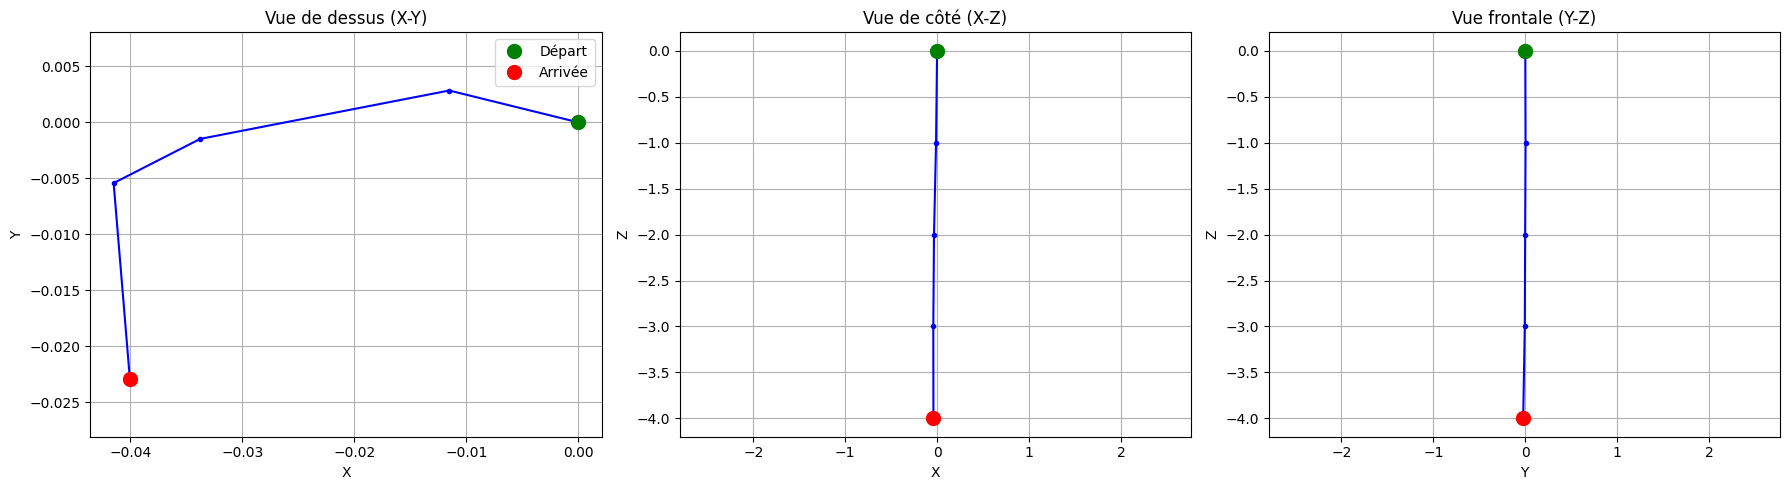

Visualisation 2D de la trajectoire solvePnP (avec SIFT features):


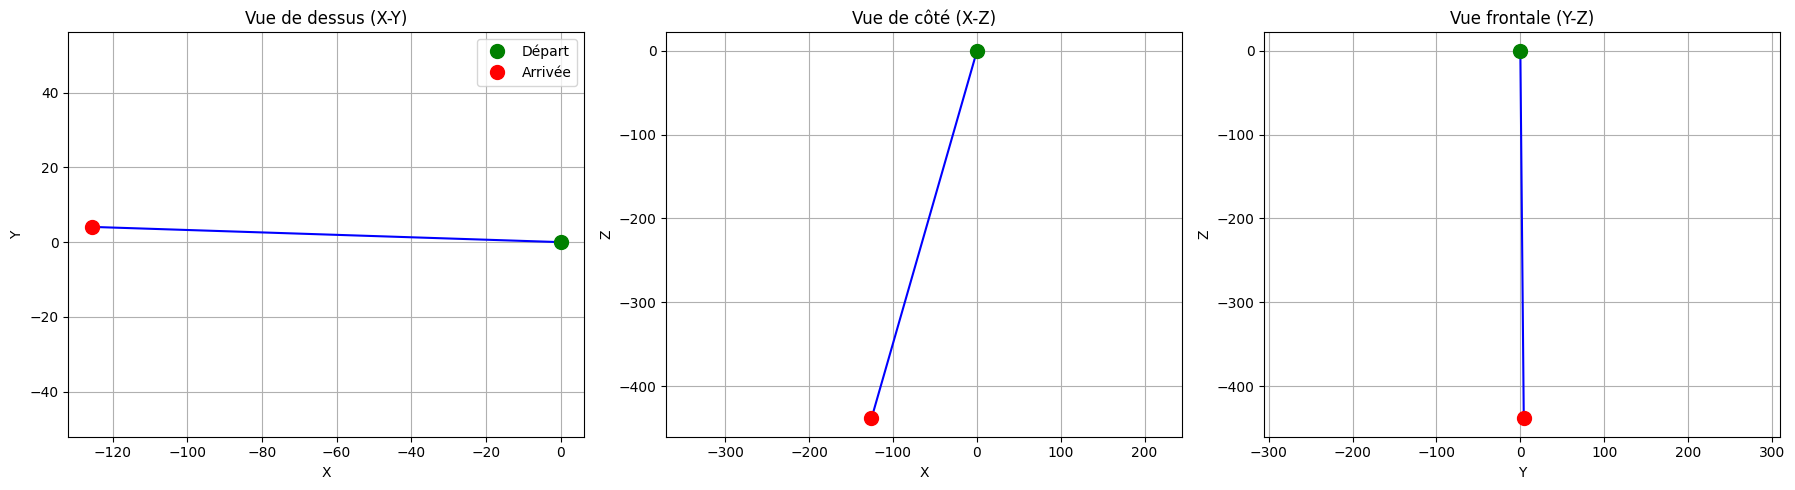

In [57]:
print("Visualisation 2D de la trajectoire SIFT (avec Essential Matrix):")
visualize_trajectory_2d(poses_sift)

print("Visualisation 2D de la trajectoire solvePnP (avec SIFT features):")
visualize_trajectory_2d(poses_pnp)


**Trajectoire SIFT** (avec Matrice Essentielle) : Les vues 2D (X-Y, X-Z, Y-Z) de la trajectoire SIFT montrent un déplacement régulier et une forme de courbe douce, indiquant un mouvement de caméra bien estimé tout au long de la séquence.

**Trajectoire solvePnP** : Les vues 2D de la trajectoire solvePnP confirment l'observation de la visualisation 3D : la trajectoire présente des points superposés pour les images où solvePnPRansac a échoué. Cela signifie que la caméra n'a pas été estimée comme ayant bougé pour ces images, résultant en une trajectoire "hachée" ou stagnante par endroits.

#### Pour cette séquence particulière, la méthode de la Matrice Essentielle (utilisant SIFT) a fourni une estimation de trajectoire plus complète et continue. La méthode solvePnP a rencontré des difficultés, probablement dues à la perte de correspondances 3D-2D fiables entre les images, ce qui a conduit à des estimations de pose stagnantes.